Metemos todas las funciones aquí por comoidad

In [29]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.integrate as inte
from matplotlib.colors import LinearSegmentedColormap

from pylab import rcParams
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', serif='Palatino')

#para que en jupytter se vean mejor las graficas
%config InlineBackend.figure_format = 'svg'

# folllowing lines taken form: https://github.com/cbnfreitas/kuramoto_model_integrate_and_plot
def chop_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

#This cmap is applied in to node coloring 
#cmap_aux = LinearSegmentedColormap.from_list("", ["cyan","#580058"])
#see https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib for colors
cmap_aux = LinearSegmentedColormap.from_list("", ["red","yellow"])

#In gray scale, cyan becomes almost white, this is why we chop the begining of the color map
cyan_purple_cmap = chop_colormap(cmap_aux, 0.00, 1)
ccmap_aux = LinearSegmentedColormap.from_list("", ["darkred","red","yellow","red","darkred"])
'''
viridis = plt.cm.get_cmap('viridis', 12)
ccmap_aux = LinearSegmentedColormap.from_list("", [viridis(.01),viridis(.1),viridis(.2),
                                                   viridis(.3),viridis(.4),viridis(.5),
                                                   viridis(.6),viridis(.7),viridis(.8),viridis(0.9),viridis(.99),
                                                  viridis(.9),viridis(.8),viridis(.7),
                                                   viridis(.6),viridis(.5),viridis(.4),
                                                  viridis(.3),viridis(.2),viridis(.1),
                                                  viridis(.01),])
'''
psi_purple_cmap = chop_colormap(ccmap_aux, 0.00, 1)

def frequency_to_color(w):
    colors_cyan_purple = cyan_purple_cmap(np.linspace(0, 1, 1001))
    w_min = min(w)
    w_max = max(w)
    return [colors_cyan_purple[int(1000*(w[i] - w_min)/(w_max - w_min))] for i in range(len(w))]

def angle_to_color(w):
    colors_cyan_purple = psi_purple_cmap(np.linspace(0, 1, 1001))
    w_min = min(w)
    w_max = max(w)
    return [colors_cyan_purple[int(1000*(w[i] - w_min)/(w_max - w_min))] for i in range(len(w))]


# me gustan más estos colores para los plots
def colores_tableau():
    # Sources: http://www.randalolson.com/2014/06/28/how-to-make
    #            -beautiful-data-visualizations-in-python-with-matplotlib/
    # These are the "Tableau 20" colors as RGB.   
    tableau20=[(31, 119, 180),  (174, 199, 232), (255, 127, 14),  (255, 187, 120),    
               (44, 160, 44),   (152, 223, 138), (214, 39, 40),   (255, 152, 150),    
               (148, 103, 189), (197, 176, 213), (140, 86, 75),   (196, 156, 148),    
               (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
               (188, 189, 34),  (219, 219, 141), (23, 190, 207),  (158, 218, 229)]
    # Scale the RGB values to the [0, 1] range, which is the format matplotlib
    # accepts.    
    for i in range(len(tableau20)):    
        red, green, blue = tableau20[i]    
        tableau20[i] = (red / 255., green / 255., blue / 255.) 
    return tableau20

tableau20 = colores_tableau()

def write_directed_vertex_list_to_file(g, filename):
    A=np.array(g.edges())
    A=np.append(A,A[:,[1,0]], axis=0)
    A=np.array(A[A[:,0].argsort()]).astype(int)
    np.savetxt(filename, A, fmt='%i')
    
def velocity(t, y, arg1):
    c = arg1[0]
    w = arg1[1]
    A = arg1[2]
    y = np.matrix(y)
    ones = np.matrix(np.ones(NODE_NR)).T
    s=np.sin(ones*(y)-y.T*(ones.T))
    out = [(s[i]*A[i].T).item() for i in range(len(A))]
    return w+np.squeeze(np.asarray(c*np.matrix(out)))


def jacobian(t, y, arg2):
    c = arg2[0]
    neigh = arg2[1]
    #y = np.matrix(y)
    #ones = np.matrix(np.ones(NODE_NR)).T
    #s=np.cos(ones*(y)-y.T*(ones.T))
        
    jac = [[0 for j in range(0,NODE_NR)] for i in range(0,NODE_NR)]
    
    #diagonal terms
    for i in range(0,NODE_NR):
        suma = 0
        for j in neigh[i]:
            suma = suma + np.cos(y[j]-y[i]) 
        suma = -c*suma
        jac[i][i] = suma
    
    # off diagonal terms
    for i in range(0,NODE_NR):
        for j in neigh[i]:
            jac[i][j] =  c * np.cos(y[j]-y[i])
    
    return jac

def r_psi(theta,dt):
    z = sum(np.exp(theta*1j))/len(theta)
    lenz=len(z)
    weff_real = np.zeros(lenz)
    for i in range(0,lenz-1):
        weff_real[i] = np.angle(z[i+1]/z[i])/dt
    weff_real[lenz-1]=weff_real[lenz-2]
    
    
    weff_med = [np.diff(theta[i])/dt  for i in range(0,len(theta))]
    weff_med = sum(weff_med)/len(theta)
    weff_medida = np.zeros(lenz)
    for i in range(0,lenz-1):
        weff_medida[i] = weff_med[i]
    weff_medida[lenz-1] = weff_med[lenz-2]
    
    return np.array([np.absolute(z), np.angle(z), weff_real, weff_medida])

def r_psi_comp(theta, conn, dt):
    #z = (np.exp(theta*1j))
    # cada elto de out sera las r(t),psi(t) de una de las componentes disconexas
    out = []
    zc = 0
    weff_med = [np.diff(theta[i])  for i in range(0,len(theta))]
    for comp in conn:
        a = []
        for j in comp:
            # estamos metiendo todos los nodos j que pertenecem
            # a conn[i] en una lista para sumar despues
            a.append(np.exp(theta[j]*1j))  
        zc = sum(a)/len(comp)
        
        lenz=len(zc)
        ayx = np.zeros(lenz)
        for i in range(0,lenz-1):
            ayx[i] = np.angle(zc[i+1]/zc[i])/dt
        ayx[lenz-1]=ayx[lenz-2]
        weff_real = ayx

        b = []
        for j in comp:
            b.append(theta[j])
        bc = sum(b)/len(comp)
        abc = np.zeros(lenz)
        for i in range(0,lenz-1):
            abc[i] = (bc[i+1]-bc[i])/dt
        abc[lenz-1]=abc[lenz-2]
        weff_medida = abc
        
        out.append(np.array([np.absolute(zc), np.angle(zc),  weff_real, weff_medida]))
    return out

def without_transient(vec, t_transient):
    return vec[int(t_transient*(TIME_FINAL-TIME_INITIAL)/len(vec)) : -1]

def mean_sig_components (out_comp, t_transient):
    r_mean_comp = []
    r_sig_comp  = []
    w_r_mean_comp = []
    w_r_sig_comp = []
    w_m_mean_comp = []
    w_m_sig_comp = []
    for i in range(0,len(out_comp)):
        aux_vec_no_transient = without_transient(out_comp[i][0], t_transient)
        r_mean_comp.append(np.mean(aux_vec_no_transient))
        r_sig_comp.append(np.sqrt(np.var(aux_vec_no_transient)))
        
        aux_vec_no_transient = without_transient(out_comp[i][2], t_transient)
        w_r_mean_comp.append(np.mean(aux_vec_no_transient))
        w_r_sig_comp.append(np.sqrt(np.var(aux_vec_no_transient)))
        
        aux_vec_no_transient = without_transient(out_comp[i][3], t_transient)
        w_m_mean_comp.append(np.mean(aux_vec_no_transient))
        w_m_sig_comp.append(np.sqrt(np.var(aux_vec_no_transient)))
    return r_mean_comp, r_sig_comp, w_r_mean_comp, w_r_sig_comp, w_m_mean_comp, w_m_sig_comp
 
    
def plot_on_argand_plane(r, psi, out_comp):
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.title(r"Dibujo de $z=r(t)e^{i\theta (t)}$ total")
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    aux_r = r
    aux_psi = psi
    aux_n = len(aux_r)
    plt.plot(aux_r*np.cos(aux_psi),
             aux_r*np.sin(aux_psi),
             label=r"$z_{\mathrm{tot}}$",
             color = tableau20[0])
    plt.legend()

    plt.subplot(1,2,2)
    plt.title(r"Dibujo de $z=r(t)e^{i\theta (t)}$ de las comptes")
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    for i in range(0,len(out_comp)):
        aux_r = out_comp[i][0]
        aux_psi = out_comp[i][1]
        aux_n = len(aux_r)
        plt.plot(aux_r*np.cos(aux_psi),
                 aux_r*np.sin(aux_psi),
                 c=tableau20[0],
                 label=r"$z_{"+str(i)+"}$")
    #plt.legend()

    
def plot_generic(r, psi,weff_real, weff_medida, out_comp):
    #plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    #plt.style.use('ggplot')
    #plt.style.use('seaborn-talk')

    plt.figure(figsize=(10,6))

    time = t

    plt.subplot(2, 2, 1)
    plt.ylim([0,1.1])
    plt.title("Magnitudes totales")
    plt.plot(time,r,color=tableau20[0])#,label=r"$r$")
    plt.ylabel(r'$r$')
    
    plt.subplot(2, 2, 3)
    #plt.ylim([-np.pi,+np.pi])
    plt.plot(time,psi,color=tableau20[0],
             label=r"$\psi$")
    plt.plot(time, weff_real, color='red',#tableau20[0],
             label=r"$\frac{\mathrm{d}\psi}{\mathrm{d}t}$")
    #plt.plot(time, weff_medida, color=tableau20[2],label=r"$\omega_{\mathrm{approx}}$")
    plt.ylabel(r'$\psi$')
    plt.xlabel(r'$t$')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.title("Magnitudes clusters, de mayor a menor (de 0 a ....)")
    plt.ylim([0,1.1])
    for i in range(0,len(out_comp)):
        plt.plot(time,out_comp[i][0],label=r"$r_"+str(i)+"$")
    plt.ylabel(r'$r_{i}$')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    #plt.ylim([-np.pi,+np.pi])
    for i in range(0,len(out_comp)):
        plt.plot(time,out_comp[i][1],label=r"$\psi_"+str(i)+"$")
        plt.plot(time, out_comp[i][2],label=r"$\omega_{\mathrm{real}}$-"+str(i))
        #plt.plot(time, out_comp[i][3],label=r"$\omega_{\mathrm{approx}}$-"+str(i))
    plt.ylabel(r'$\psi_{i}$')
    plt.xlabel(r'$t$')
    plt.legend()
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
    

#METHOD = 'RK45'
#ints = solve_ivp(lambda t,y: velocity(t,y,[COUPLING,w,A]),
#                y0=theta_0,
#                t_span=[TIME_INITIAL,TIME_FINAL],
#                method=METHOD,
#                dense_output=False)

Ahora vamos a definir la red sobre la que realizaremos la simulación.

In [30]:
g=nx.Graph()

#for i in range(0,10):
#    g.add_node(i)
#g.add_node(10)

#Ahora definimos 4 componentes: dos grandes, dos pequeñas. Quiero que tenga dos sincronizadas y dos sin sincronizar.
# los nodos extra estan para simular"otras componentes sincronziadas" me dan igual cuales son
'''
g.add_edge(39,38)
g.add_edge(37,36)
g.add_edge(35,34)
'''

'''
g.add_edge(1,2)
g.add_edge(1,3)
g.add_edge(1,4)
g.add_edge(4,3)
g.add_edge(4,0)
g.add_edge(8,7)
'''


'''
g.add_edge(7,6)
g.add_edge(2,8)
g.add_edge(6,4)
g.add_edge(6,8)
g.add_edge(6,2)
g.add_edge(7,9)


g.add_edge(21,22)
g.add_edge(21,23)
g.add_edge(21,25)
g.add_edge(21,24)
g.add_edge(24,23)
g.add_edge(20,19)
g.add_edge(19,26)
g.add_edge(22,20)
g.add_edge(26,24)
g.add_edge(26,25)
g.add_edge(26,22)
g.add_edge(25,20)


g.add_edge(11,12)
g.add_edge(12,18)
g.add_edge(15,18)


g.add_edge(17,10)
g.add_edge(17,5)
g.add_edge(17,16)

g.add_edge(13,14)
g.add_edge(13,0)

'''
#sueltos:
#0
#17
#19

# comentarios con acoplo 5
#g.add_edge(8,24) 
#g.add_edge(12,16) 
#g.add_edge(12,8)
#g.add_edge(7,16) 
#g.add_edge(12,23)
#g.add_edge(22,5)

#g = nx.barabasi_albert_graph(30, 3)

g = nx.erdos_renyi_graph(100,0.007)
'''
side = 10
g = nx.generators.lattice.grid_graph(dim=[side, side])
NODE_NR = g.number_of_nodes()
g = nx.convert_node_labels_to_integers(g, first_label=0, ordering='default', label_attribute=None)
nx.write_edgelist(g, "../nx_edgelist_lattice_100.txt")
'''


#g = nx.to_dict_of_dicts(g)
#g = nx.to_networkx_graph(g)
#g = nx.gnm_random_graph(20, 20*4)
#write_directed_vertex_list_to_file(g,'net.net')

'''
numero_nodos = 30
for i in range(0,numero_nodos):
    g.add_node(i)

for i in range(0,30):
    rnd1 = np.random.randint(0,numero_nodos)
    rnd2 = np.random.randint(0,numero_nodos)
    g.add_edge(rnd1,rnd2)
'''

#g = nx.balanced_tree(3, 3)
#g.add_node(33)

#E=np.loadtxt('net.net')

'''

A = nx.adjacency_matrix(g)
A = nx.to_numpy_matrix(g)

C = np.zeros((int(NODE_NR),int(NODE_NR)))-1
for i in range(0,NODE_NR):
    k=0
    for j in range(0,NODE_NR): 
        if A[i,j]!=0:
            C[i][k]=j
            k = k + 1
            
#g=nx.read_adjlist("net.net")

# Lo siguiente es para tener las componentes separadas.
connctd = sorted(nx.connected_components(g), key=len, reverse=True)
connctd = [np.array((list(i)),dtype=int) for i in connctd]
mat_C = []
for comp in connctd:
    mat_C.append(np.zeros(NODE_NR))
    for j in range(0,len(comp)):
        mat_C[-1][comp[j]] = 1
mat_C = np.array(mat_C)

neighbors = [[] for i in range(0,NODE_NR)]
for i in range(0,NODE_NR):
    for j in range(0,NODE_NR):
        if C[i][j]!=-1:
            neighbors[i].append(int(C[i][j]))

#plt.figure(figsize=(8,5))

#print(g.nodes())

'''
print('2')


2


In [6]:
import random

random.seed(22)

node_nr_aux = 100
NODE_NR = node_nr_aux

node_list = []
for i in range(0,node_nr_aux):
    node_list.append(i)

g_graph = nx.Graph()
for node in node_list:
    g_graph.add_node(node)


edge_list = []    
total_edge_number = int(3*node_nr_aux)
for i in range(0,total_edge_number):
    n1 = random.choice(node_list)
    n2 = random.choice(node_list)
    g_graph.add_edge(n1,n2)
    edge_list.append([n1,n2])

    
NODE_NR = g.number_of_nodes()

#POS_FINAL=nx.spring_layout(g_graph, iterations=15)


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (51) of font (C:/Program Files/MiKTeX 2.9/fonts/type1/urw/palatino/uplr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (50) of font (C:/Program Files/MiKTeX 2.9/fonts/type1/urw/palatino/uplr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The

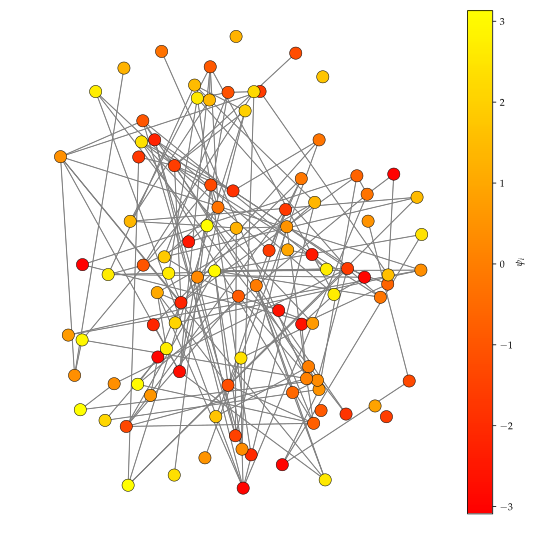

In [7]:
random.seed(22)
np.random.seed(77)
#w=-0.5+(0.5--0.5)*np.random.rand(NODE_NR)
w=np.random.normal(5, 1, NODE_NR)
theta_0 = 0 + 2*np.pi*np.random.rand(NODE_NR)
#COUPLING = 0.5

plt.figure(figsize=(7,7))

g = nx.Graph()
for node in node_list:
    g.add_node(node)
    
edge_number = 170 #int(0.5*total_edge_number)
for i in range(0,edge_number):
    if i < total_edge_number:
        g.add_edge(edge_list[i][0],edge_list[i][1])
    if i > total_edge_number:
        n1 = random.choice(node_list)
        n2 = random.choice(node_list)
        g.add_edge(n1,n2)
        #edge_list.append([n1,n2])
    
#colors_w = frequency_to_color(theta_0)
colors_w = angle_to_color(theta_0)
nx.draw(g, node_size=150, node_color = colors_w, 
        pos=POS_FINAL,
        edge_color = 'gray',
        with_labels=False, font_size=10, font_color='white')

Gcc = sorted(nx.connected_component_subgraphs(g), key=len, reverse=True)
G0 = Gcc[0]

for i in range(0,len(Gcc)):
    if i!=0:
        nx.draw_networkx_edges(Gcc[i], pos=POS_FINAL,
                       with_labels=False,
                       edge_color='gray'
                      )
        '''
        nx.draw_networkx_nodes(Gcc[i], pos=POS_FINAL,
                       with_labels=False,
                       node_size=150, node_color ='gray', edgecolor='black'
                      )
        '''

nx.draw_networkx_edges(G0, pos=POS_FINAL,
       with_labels=False,
       edge_color='gray',
       #width=4.0,
       #alpha=0.6
      )
'''
nx.draw_networkx_nodes(G0, pos=POS_FINAL,
                       with_labels=False,
                       node_size=150, node_color ='red', edgecolor='black'
                      )
'''
ax = plt.gca()
ax.collections[0].set_edgecolor("black") #Drawing a black border around nodes.
ax.collections[0].set_linewidth(0.5)
ax.collections[1].set_linewidth(0.5)  # Change edges linewidth



ccmap_aux
#cyan_purple_cmap
sm = plt.cm.ScalarMappable(cmap=cyan_purple_cmap, norm=plt.Normalize(vmin=0, vmax=2*np.pi))
sm._A = []
cb1 = plt.colorbar(sm)
cb1.set_label(r'$\psi_i$')


plt.savefig('graph_tree'+str(edge_number)+'_nored_colorbarYES.png',dpi=1200)

Condiciones iniciales

Integracion. Uso un metodo algo ineficiente, pero para pocos nodos debería darigual

In [9]:
#np.random.seed(77)
#w=(-0.5+(0.5--0.5)*np.random.rand(NODE_NR))+1.0
#w=np.random.normal(5, 1, NODE_NR)
#theta_0 = -np.pi + 2*np.pi*np.random.rand(NODE_NR)

g = g_graph

COUPLING = 0.37
TIME_INITIAL = 0.0
TIME_FINAL = 20.0
#DT = (TIME_FINAL-TIME_INITIAL)/100
DT = 0.001

def EVOLVE(g,theta_0,w,time_ini,time_fin,dt):
    NODE_NR = g.number_of_nodes()

    A = nx.adjacency_matrix(g)
    A = nx.to_numpy_matrix(g)

    C = np.zeros((int(NODE_NR),int(NODE_NR)))-1
    for i in range(0,NODE_NR):
        k=0
        for j in range(0,NODE_NR): 
            if A[i,j]!=0:
                C[i][k]=j
                k = k + 1

    #g=nx.read_adjlist("net.net")

    # Lo siguiente es para tener las componentes separadas.
    connctd = sorted(nx.connected_components(g), key=len, reverse=True)
    connctd = [np.array((list(i)),dtype=int) for i in connctd]
    mat_C = []
    for comp in connctd:
        mat_C.append(np.zeros(NODE_NR))
        for j in range(0,len(comp)):
            mat_C[-1][comp[j]] = 1
    mat_C = np.array(mat_C)

    neighbors = [[] for i in range(0,NODE_NR)]
    for i in range(0,NODE_NR):
        for j in range(0,NODE_NR):
            if C[i][j]!=-1:
                neighbors[i].append(int(C[i][j]))
    
    INTEGRATOR = 'lsoda'

    ode = inte.ode(lambda t,y: velocity(t,y,[COUPLING,w,A]),
                   lambda t,y: jacobian(t,y,[COUPLING,neighbors]))
    ode.set_integrator(INTEGRATOR)
    ode.set_initial_value(theta_0, TIME_INITIAL)


    t = []
    t.append(ode.t)
    ode.integrate(ode.t + DT)
    y_t = ode.y
    #y_t_dot = velocity(0, y_t, [COUPLING,w,A])
    y_t = [[y_t[i]] for i in range(0,NODE_NR)]
    #y_t_dot = [[y_t_dot[i]] for i in range(0,NODE_NR)]
    while ode.successful() and ode.t < TIME_FINAL:
        ode.integrate(ode.t + DT)
        t.append(ode.t)
        for i in range(0, NODE_NR):
            y_t[i].append(ode.y[i])
    #        y_t_dot[i].append(velocity(0, ode.y[i], [COUPLING,w,A]))
    #print(y_t[0])
    y_t = [np.array(y_t[i]) for i in range(0,len(y_t))]
    y_t = np.array(y_t)

    #asd = ints.y
    asd = y_t
    return [asd, t, []]

In [19]:
'''
data = np.genfromtxt("../pattern.txt")
data = np.transpose(data)
list_dat = list(data)
t = list_dat.pop(0)
asd = np.array(list_dat)
'''

[asd, t, connctd] = EVOLVE(g, theta_0, w, TIME_INITIAL, TIME_FINAL, DT)
#connctd =[] 

out_comp = r_psi_comp(asd, connctd, DT)
r, psi, weff_real, weff_medida = r_psi(asd, DT)
TRANSIENT = 0

r_without_transient = without_transient(r, TRANSIENT)
r_mean = np.mean(r_without_transient)
r_var = np.sqrt(np.var(r_without_transient))

weff_medida_without_transient = without_transient(weff_real, TRANSIENT)
w_mean = np.mean(weff_medida_without_transient)
w_var = np.sqrt(np.var(weff_medida_without_transient))

r_mean_comp, r_sig_comp, w_r_mean_comp, w_r_sig_comp, w_m_mean_comp, w_m_sig_comp = mean_sig_components(out_comp, TRANSIENT)

array([[ 2.68153278,  2.68529249,  2.68905091, ..., -1.59886919,
        -1.59671675, -1.59456244],
       [-0.29675468, -0.29621792, -0.29568314, ...,  2.52838716,
         2.52837629,  2.52836452],
       [-0.6809726 , -0.68207106, -0.68316882, ..., -1.19150535,
        -1.19160491, -1.19170379],
       ...,
       [ 0.49944089,  0.49986755,  0.50029463, ..., -0.13953341,
        -0.13902672, -0.13852008],
       [-3.09317039, -3.09587073, -3.09857267, ...,  2.07404329,
         2.0712743 ,  2.06850369],
       [ 1.230316  ,  1.23191082,  1.23350748, ...,  0.69750856,
         0.69805045,  0.69859134]])

Ahora tocan plots. La $\omega_{\mathrm{real}}$ se calcula como la derivada temporal de $\psi$ de $re^{i\psi}=\sum e^{i\theta_i}$. La llamo "real" porque no es promedio de $\dot{\theta}_i$, sino es la derivada de la fase global.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Promedios totales:
r total = 0.60+-0.20
w total = 4.95+-0.46
Por componentes:
r_comp:  []
w_comp:  []
w:  ['5.22', '5.66', '4.42', '5.41', '5.47', '3.03', '5.28', '3.42', '6.57', '4.28', '5.31', '6.16', '3.95', '4.02', '4.36', '6.70', '3.71', '4.81', '4.93', '4.84', '4.89', '4.30', '3.99', '4.61', '2.86', '6.76', '4.23', '4.47', '4.21', '5.29', '3.78', '3.43', '5.40', '4.95', '4.08', '6.12', '5.20', '5.28', '4.12', '3.90', '4.78', '3.97', '4.83', '5.56', '5.81', '4.87', '4.85', '5.07', '5.02', '3.88', '3.27', '5.89', '4.56', '4.36', '5.43', '5.83', '6.09', '4.86', '3.59', '6.16', '4.01', '5.11', '4.46', '5.62', '7.91', '6.67', '5.49', '4.73', '5.60', '4.89', '4.90', '6.49', '4.65', '6.19', '5.19', '4.91', '4.86', '5.18', '5.16', '4.10', '5.60', '6.47', '5.96', '5.15', '6.06', '4.27', '4.31', '4.06', '4.07', '4.16', '5.03', '4.87', '4.59', '5.62', '4.79', '6.06', '6.59', '4.48', '6.89', '4.78']
comptes: []


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (53) of font (C:/Program Files/MiKTeX 2.9/fonts/type1/urw/palatino/uplr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (46) of font (C:/Program Files/MiKTeX 2.9/fonts/type1/urw/palatino/uplr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (52) of font (C:/Program Files/MiKTeX 2.9/fonts/type1/urw/palatino/uplr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (54) of font (C:/Program Files/MiKTeX 2.9/fonts/type1/urw/palatino/uplr8a.pfb) cannot be converted with t

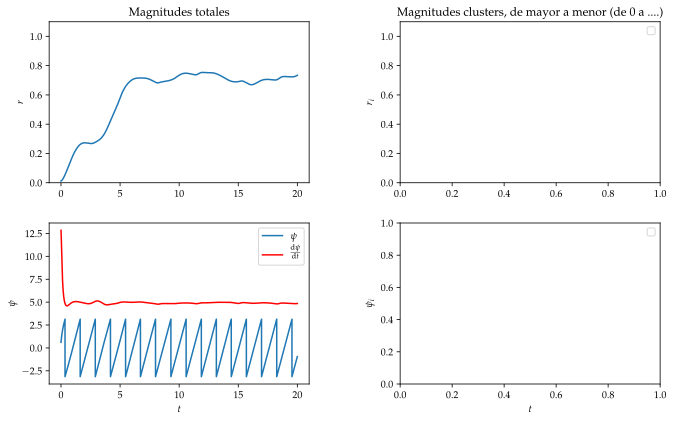

In [12]:
print("Promedios totales:")
print("r total = "+"{:.2f}".format(r_mean)+"+-"+"{:.2f}".format(r_var))
print("w total = "+"{:.2f}".format(w_mean)+"+-"+"{:.2f}".format(w_var))

print("Por componentes:")
print("r_comp: ",["{:.2f}".format((r_mean_comp[i]))+"+-"+"{:.2f}".format(np.sqrt(np.var(out_comp[i][0])))
                   for i in range(0,len(r_mean_comp))])
print("w_comp: ",["{:.2f}".format((w_r_mean_comp[i]))+"+-"+"{:.2f}".format(np.sqrt(np.var(out_comp[i][2])))
                   for i in range(0,len(w_r_mean_comp))])
print("w: ",["{:.2f}".format((w[i])) for i in range(0,len(w))])
print("comptes:",connctd)

plot_generic(r, psi, weff_real, weff_medida, out_comp)
plt.savefig("plt_generic.pdf")

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (68) of font (C:/Program Files/MiKTeX 2.9/fonts/type1/urw/palatino/uplr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (98) of font (C:/Program Files/MiKTeX 2.9/fonts/type1/urw/palatino/uplr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (106) of font (C:/Program Files/MiKTeX 2.9/fonts/type1/urw/palatino/uplr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font.fname))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:349: UserWarning: The glyph (122) of font (C:/Program Files/MiKTeX 2.9/fonts/type1/urw/palatino/uplri8a.pfb) cannot be converted wit

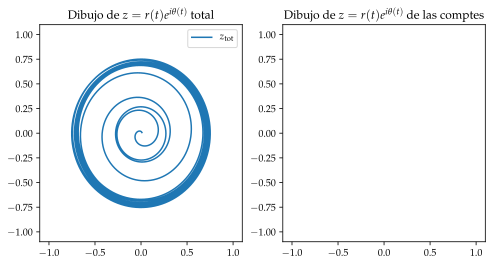

In [13]:
plot_on_argand_plane(r, psi, out_comp)
plt.savefig("argand.pdf")

A partir de aquí casi es un nuevo programa

In [14]:
'''
filename_in = "../data/FG_N=500_m=1_4_a=5_sig=0.08_EDGELIST_1.txt"
datos = (np.genfromtxt(filename_in,skip_header=0))
xdat=datos[:,1]
ydat=datos[:,2]
e1 = [int(xdat[i]) for i in range(0,len(xdat))]
e2 = [int(ydat[i]) for i in range(0,len(ydat))]
my_edge_list = [[e1[i],e2[i],datos[i,0]] for i in range(0,len(e1))]
my_edge_list = np.array(my_edge_list, dtype=np.int)
I1 = np.max(my_edge_list[:,0])
I2 = np.max(my_edge_list[:,1])
NODE_NR = np.max([I1,I2])+1
NODE_NR
'''

'\nfilename_in = "../data/FG_N=500_m=1_4_a=5_sig=0.08_EDGELIST_1.txt"\ndatos = (np.genfromtxt(filename_in,skip_header=0))\nxdat=datos[:,1]\nydat=datos[:,2]\ne1 = [int(xdat[i]) for i in range(0,len(xdat))]\ne2 = [int(ydat[i]) for i in range(0,len(ydat))]\nmy_edge_list = [[e1[i],e2[i],datos[i,0]] for i in range(0,len(e1))]\nmy_edge_list = np.array(my_edge_list, dtype=np.int)\nI1 = np.max(my_edge_list[:,0])\nI2 = np.max(my_edge_list[:,1])\nNODE_NR = np.max([I1,I2])+1\nNODE_NR\n'

In [15]:
'''
data = np.genfromtxt("../pattern.txt")
data = np.transpose(data)
list_dat = list(data)
t = list_dat.pop(0)
delta_t_trash = list_dat.pop(0)
asd = np.array(list_dat)
t = [int(t[i]) for i in range(len(t))]

nr_e_ini = np.min(t)
nr_e_fin = np.max(t)
nr_e_ini
'''


'\ndata = np.genfromtxt("../pattern.txt")\ndata = np.transpose(data)\nlist_dat = list(data)\nt = list_dat.pop(0)\ndelta_t_trash = list_dat.pop(0)\nasd = np.array(list_dat)\nt = [int(t[i]) for i in range(len(t))]\n\nnr_e_ini = np.min(t)\nnr_e_fin = np.max(t)\nnr_e_ini\n'

In [16]:
'''
g_aux = nx.Graph()
for i in range(0,NODE_NR):
    g_aux.add_node(i)
for i in range(0,len(my_edge_list)):
    g_aux.add_edge(my_edge_list[i][0],my_edge_list[i][1])

g_aux.add_edge(0,432)
    
#connctd = sorted(nx.connected_components(g_aux), key=len, reverse=True)
#connctd = [np.array((list(i)),dtype=int) for i in connctd]
    
fig = plt.figure(figsize=(7,7))
#POS_FINAL = nx.spring_layout(g_aux, iterations=10000)
#POS_FINAL = nx.fruchterman_reingold_layout(g_aux)
'''




'''
filenmame_pos_final_save = "file_pos_final_10000_1.txt"
file_pos_final = open(filenmame_pos_final_save,"w")
for i in POS_FINAL.items():
    file_pos_final.write(str(i[0])+" "+str(i[1][0])+" "+str(i[1][1])+"\n")
file_pos_final.close()
'''




'''
filenmame_pos_final_load = "file_pos_final_10000_1.txt"
POS_FINAL_AUX = np.genfromtxt(filenmame_pos_final_load)
POS_FINAL = {}
for i in POS_FINAL_AUX:
    POS_FINAL[int(i[0])] = np.array([float(i[1]),float(i[2])])

    
    

nx.draw(g_aux, pos=POS_FINAL, node_size=40,  edge_color = 'black', with_labels=False, font_size=10, font_color='white')

POS_FINAL
'''

'\nfilenmame_pos_final_load = "file_pos_final_10000_1.txt"\nPOS_FINAL_AUX = np.genfromtxt(filenmame_pos_final_load)\nPOS_FINAL = {}\nfor i in POS_FINAL_AUX:\n    POS_FINAL[int(i[0])] = np.array([float(i[1]),float(i[2])])\n\n    \n    \n\nnx.draw(g_aux, pos=POS_FINAL, node_size=40,  edge_color = \'black\', with_labels=False, font_size=10, font_color=\'white\')\n\nPOS_FINAL\n'

Ahora vamos a animar.

2019-07-06 19:19:20.602378


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


KeyboardInterrupt: 

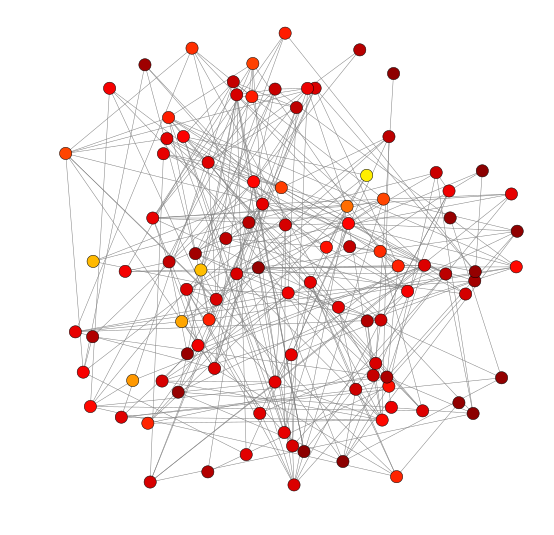

In [17]:
import matplotlib.animation as animation
from IPython.core.display import display, HTML
display(HTML('<h1> Animation attempt. </h1>'))


import matplotlib.animation as animation

#%pylab qt
 

plt.rcParams['animation.ffmpeg_path'] = 'c://ffmpeg-4.1.1-win64-static//bin//ffmpeg.exe'
fig = plt.figure(figsize=(7,7))
#param, = plt.plot(t,y_t[1])
ang_2pi = np.linspace(0,2*np.pi,num=1000)
#colors_w = frequency_to_color(w)


def update_argand(i):
    fig.clf()
    
    
    for node in range(0,NODE_NR):
        plt.scatter(np.cos(asd[node][i]),np.sin(asd[node][i]),facecolor=colors_w[node], # color='b',
                marker='o', linewidth=0.5, zorder=3, edgecolor='gray', s = 100)
        
    plt.scatter(r[i]*np.cos(psi[i]),r[i]*np.sin(psi[i]), color='b',
                linewidth = 3, zorder=2)
    plt.plot(r[:i]*np.cos(psi[:i]),r[:i]*np.sin(psi[:i]), color='b', linewidth = 1.0, zorder=1)
    
    plt.plot(np.cos(ang_2pi),np.sin(ang_2pi), color='gray')
    
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    
    sm = plt.cm.ScalarMappable(cmap=cyan_purple_cmap, norm=plt.Normalize(vmin=min(w), vmax=max(w)))
    sm._A = []
    cb1 = plt.colorbar(sm)
    cb1.set_label(r'$\omega_i$')
    
    return fig,

#this is for growing network
'''
g = nx.Graph()
for i in range(0,NODE_NR):
    g.add_node(i)

i = 0
while (i<nr_e_ini):
    g.add_edge(my_edge_list[i][0],my_edge_list[i][1])
    i = i + 1
'''

w = asd[:,0]
colors_s = angle_to_color(w)
nx.draw(g, pos=POS_FINAL, node_size=40, node_color = colors_s,
        edge_color = 'black',
        with_labels=False, font_size=10, font_color='white')

#my_edge_list = list(g.edges())

#asd = np.mod(asd, 2*np.pi)
asd = np.angle(np.exp(asd*1j))
y_t=asd

# this is for growin network
'''
number_of_edges = g.number_of_edges()

    
edge_to_print = nr_e_ini
edge_n1_toprint = my_edge_list[edge_to_print][0]
edge_n2_toprint = my_edge_list[edge_to_print][1]

if edge_to_print != t[0]:
    print("warning 2")
'''  


def update_graph(i):
    fig.clf()
    
    w = asd[:,i]
    colors_s = angle_to_color(w)
    nx.draw(g, pos=POS_FINAL,
            node_size=150, node_color = colors_s,
        edge_color = 'gray',
        with_labels=False, font_size=10, font_color='white')
    
    ax = plt.gca()
    ax.collections[0].set_edgecolor("black") #Drawing a black border around nodes.
    ax.collections[0].set_linewidth(0.5)
    ax.collections[1].set_linewidth(0.5)  # Change edges linewidth
    
    '''
    sm = plt.cm.ScalarMappable(cmap=psi_purple_cmap, norm=plt.Normalize(vmin=0, vmax=2*np.pi))
    sm._A = []
    cb1 = plt.colorbar(sm)
    cb1.set_label(r'$\psi$')
    '''
    
    # this is to add edges in time for growing network
    '''
    edge_to_print = t[i]
    edge_n1_toprint = my_edge_list[edge_to_print][0]
    edge_n2_toprint = my_edge_list[edge_to_print][1]
        
    g.add_edge(edge_n1_toprint, edge_n2_toprint)
    H = g.edge_subgraph([(edge_n1_toprint, edge_n2_toprint)])
    nx.draw_networkx_edges(H, pos=POS_FINAL,
                       with_labels=False,
                       edge_color='r',
                       width=7.0,
                       alpha=1.0,
                       font_size=10,
                      )
    '''
    #nx.draw(g, pos=POS_FINAL, node_size=20, #node_color = colors_w,
    #    edge_color = 'black',
    #    with_labels=False, font_size=10, font_color='white')
    
    
    '''
    for node in range(0,NODE_NR):
        plt.scatter(np.cos(y_t[node][i]),np.sin(y_t[node][i]),facecolor=colors_w[node], # color='b',
                marker='o', linewidth=0.5, zorder=3, edgecolor='gray', s = 100)
        
    plt.scatter(r[i]*np.cos(psi[i]),r[i]*np.sin(psi[i]), color='b',
                linewidth = 3, zorder=2)
    plt.plot(r[:i]*np.cos(psi[:i]),r[:i]*np.sin(psi[:i]), color='b', linewidth = 1.0, zorder=1)
    
    plt.plot(np.cos(ang_2pi),np.sin(ang_2pi), color='gray')
    
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    
    sm = plt.cm.ScalarMappable(cmap=cyan_purple_cmap, norm=plt.Normalize(vmin=min(w), vmax=max(w)))
    sm._A = []
    cb1 = plt.colorbar(sm)
    cb1.set_label(r'$\omega_i$')
    '''
    #plt.title("$\ell$="+str(t[i]))
    
    return fig,

# this if for the frame by frame kuramoto plot
'''
i=1600
fig.clf()
for node in range(0,NODE_NR):
    plt.scatter(np.cos(asd[node][i]),np.sin(asd[node][i]),facecolor=colors_w[node], # color='b',
            marker='o', linewidth=0.5, zorder=3, edgecolor='gray', s = 200)

plt.scatter(r[i]*np.cos(psi[i]),r[i]*np.sin(psi[i]), color='b',
            linewidth = 3, zorder=4)
#plt.plot(r[:i]*np.cos(psi[:i]),r[:i]*np.sin(psi[:i]), color='b', linewidth = 1.0, zorder=1)

plt.plot(np.cos(ang_2pi),np.sin(ang_2pi), color='gray',zorder=1)

plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])

sm = plt.cm.ScalarMappable(cmap=cyan_purple_cmap, norm=plt.Normalize(vmin=min(w), vmax=max(w)))
sm._A = []
cb1 = plt.colorbar(sm)
cb1.set_label(r'$\omega_i$')
plt.savefig("instant_BI_2.pdf")
'''



frame = [i for i in range(0,len(t))]
ani = animation.FuncAnimation(fig, update_graph, frames=frame, interval=100,
                              blit=True)

import datetime

currentDT = datetime.datetime.now()
print (str(currentDT))
#ani = animation.FuncAnimation(fig, update_argand, frames=10,interval=10, blit=True)

ani.save('cool_animation2.mp4', fps=60, extra_args=['-vcodec', 'libx264'])
#ani.save('test.gif', writer='imagemagick')

#ani.save("movie.mp4")

#HTML(ani.to_html5_video())

currentDT = datetime.datetime.now()
print (str(currentDT))

#plt.show()

array([[2.68407331, 2.69037388, 2.69667348, ..., 5.67202253, 5.67687715,
        5.68173182],
       [5.99238295, 5.99887201, 6.00535907, ..., 6.12291414, 6.12778177,
        6.13264943],
       [5.60730846, 5.61130502, 5.61530156, ..., 4.72047805, 4.72500005,
        4.72952247],
       ...,
       [0.50341716, 0.50781984, 0.5122227 , ..., 3.94106054, 3.94594762,
        3.9508347 ],
       [3.19999115, 3.20727011, 3.21455053, ..., 3.21212664, 3.21980414,
        3.22748296],
       [1.23386393, 1.23900469, 1.2441453 , ..., 5.2557198 , 5.26060651,
        5.26549319]])

In [502]:
len(frame)

2000

In [ ]:
HTML(ani.to_html5_video())

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


In [ ]:
#ani.save('network_chula2.mp4', fps=60, extra_args=['-vcodec', 'libx264'])